In [54]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from IPython.display import FileLink
pd.set_option('float_format', '{:.4f}'.format)

In [3]:
#loading data
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [4]:
#Using pandas to store the uploaded csv file into a DataFrame.
import pandas as pd
import io
df_test = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')))
df_train = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))

In [6]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


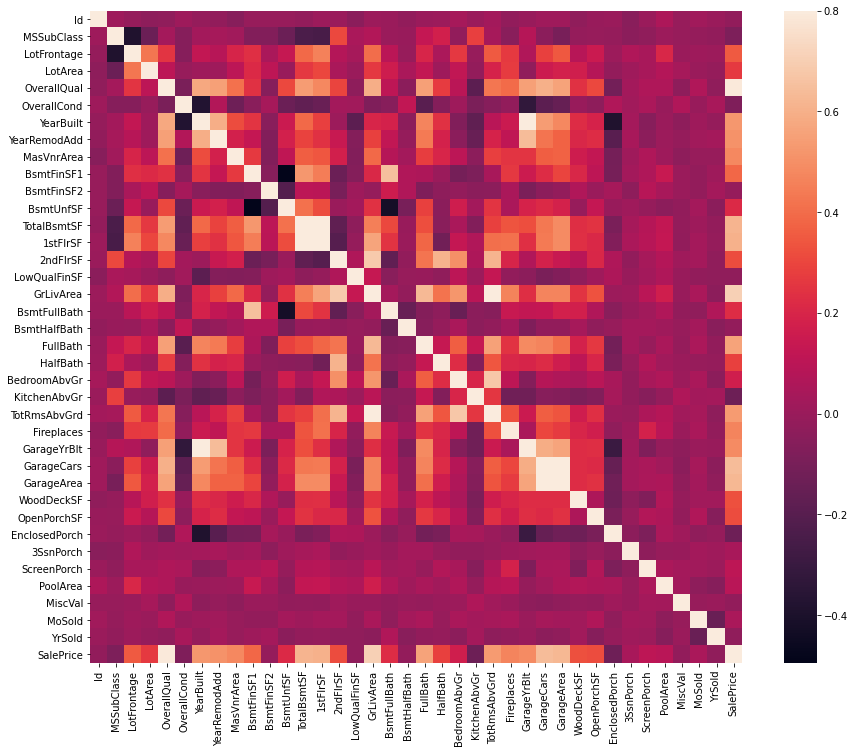

In [7]:
corr_matrix = df_train.corr()
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr_matrix, vmax=0.8, square=True)
plt.show()

In [8]:
# Selecting only the numeric columns
train = df_train.select_dtypes(['int64', 'float64'])
test = df_test.select_dtypes(['int64', 'float64'])

# Dropping the insignificant features
train = train.drop(['GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'GarageCars', 'Id'], axis=1)
test = test.drop(['GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'GarageCars', 'Id'], axis=1)

In [9]:
# Visualizing the unique value count in each feature
cat_count = train.apply(lambda x: x.value_counts().shape[0]).sort_values()
go.Figure(data=go.Bar(x=cat_count.index, y=cat_count))

In [10]:
# Categorical columns in numerical columns
cats_in_nums = cat_count.loc[cat_count < 50].index

# Converting the type of filtered numerical columns to categorical
train.loc[:, cats_in_nums] = train.loc[:, cats_in_nums].astype('object')
test.loc[:, cats_in_nums] = test.loc[:, cats_in_nums].astype('object')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   LotFrontage    1201 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   object 
 4   OverallCond    1460 non-null   object 
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1452 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  2ndFlrSF       1460 non-null   int64  
 13  LowQualFinSF   1460 non-null   object 
 14  GrLivArea      1460 non-null   int64  
 15  BsmtFullBath   1460 non-null   object 
 16  BsmtHalfBath   1460 non-null   object 
 17  FullBath       1460 non-null   object 
 18  HalfBath

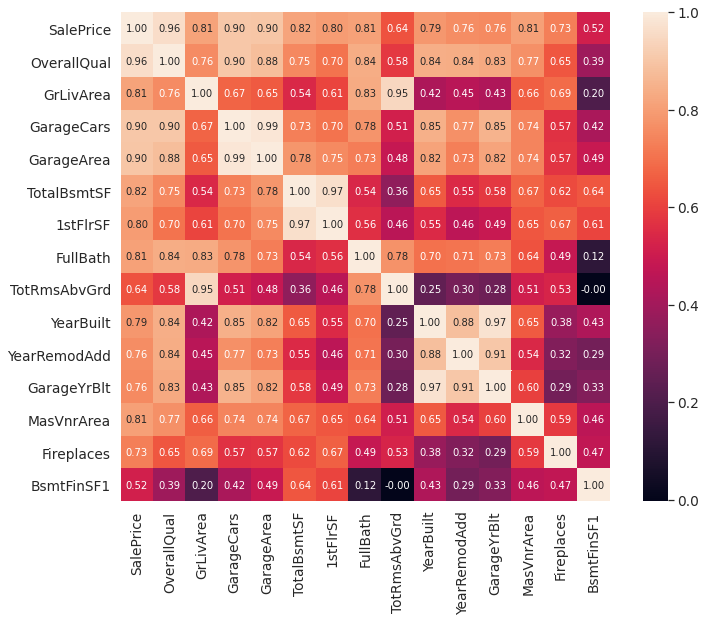

In [13]:
#Code block to view only n top correlated features
top_features = corr_matrix.nlargest(15, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(corr_matrix.loc[top_features].values)
sns.set(font_scale=1.25)
fig = plt.figure(figsize=(12, 9))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
     annot_kws={'size': 10}, yticklabels=top_features.values,
          xticklabels=top_features.values)
plt.show()

In [14]:
mean_price = df_train.groupby('Neighborhood')['SalePrice'].mean().reset_index()
px.bar(mean_price, x='Neighborhood', y='SalePrice')

In [15]:
three_bath_houses = df_train[(df_train['FullBath'] == 3)]
three_bath_houses_neigh = three_bath_houses.groupby('Neighborhood')['SalePrice'].mean().reset_index()
px.bar(three_bath_houses_neigh, x='Neighborhood', y='SalePrice')

In [16]:
large_garage_houses = df_train[(df_train['GarageArea'] >= 800)]
large_garage_houses_neigh = large_garage_houses.groupby('Neighborhood')['SalePrice'].mean().reset_index()
px.bar(large_garage_houses_neigh, x='Neighborhood', y='SalePrice')

In [17]:
#Adding Neighborhood feature to the filtered datasets
train['Neighborhood'] = df_train['Neighborhood']
test['Neighborhood'] = df_test['Neighborhood']

#Extracting the SalePrice from training data
y_train = np.log(train['SalePrice'].values)
train = train.drop(['SalePrice'], axis=1)

In [18]:
#Feature Engineering
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   LotFrontage    1201 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   object 
 4   OverallCond    1460 non-null   object 
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1452 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  2ndFlrSF       1460 non-null   int64  
 13  LowQualFinSF   1460 non-null   object 
 14  GrLivArea      1460 non-null   int64  
 15  BsmtFullBath   1460 non-null   object 
 16  BsmtHalfBath   1460 non-null   object 
 17  FullBath       1460 non-null   object 
 18  HalfBath

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   object 
 1   LotFrontage    1232 non-null   float64
 2   LotArea        1459 non-null   int64  
 3   OverallQual    1459 non-null   object 
 4   OverallCond    1459 non-null   object 
 5   YearBuilt      1459 non-null   int64  
 6   YearRemodAdd   1459 non-null   int64  
 7   MasVnrArea     1444 non-null   float64
 8   BsmtFinSF1     1458 non-null   float64
 9   BsmtFinSF2     1458 non-null   float64
 10  BsmtUnfSF      1458 non-null   float64
 11  TotalBsmtSF    1458 non-null   float64
 12  2ndFlrSF       1459 non-null   int64  
 13  LowQualFinSF   1459 non-null   object 
 14  GrLivArea      1459 non-null   int64  
 15  BsmtFullBath   1457 non-null   object 
 16  BsmtHalfBath   1457 non-null   object 
 17  FullBath       1459 non-null   object 
 18  HalfBath

In [20]:
px.histogram(train, 'GarageArea')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



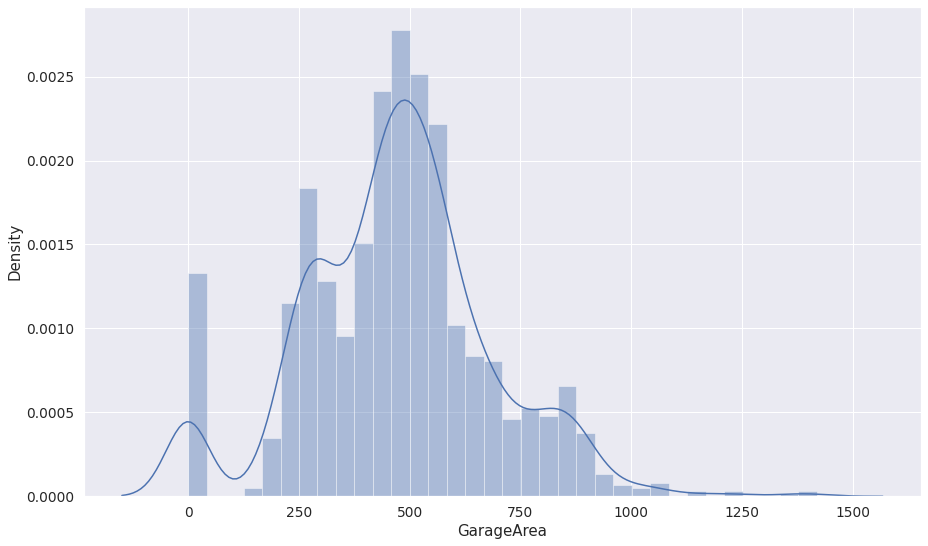

In [21]:
figure = plt.figure(figsize=(15, 9))
ax = sns.distplot(train['GarageArea'])

In [22]:
px.histogram(train, 'TotalBsmtSF')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



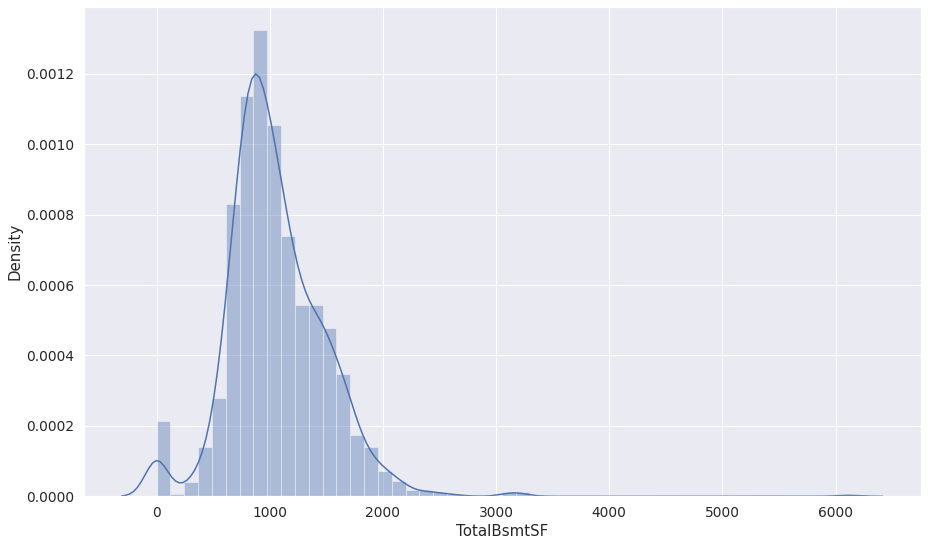

In [23]:
figure = plt.figure(figsize=(15, 9))
ax = sns.distplot(train['TotalBsmtSF'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



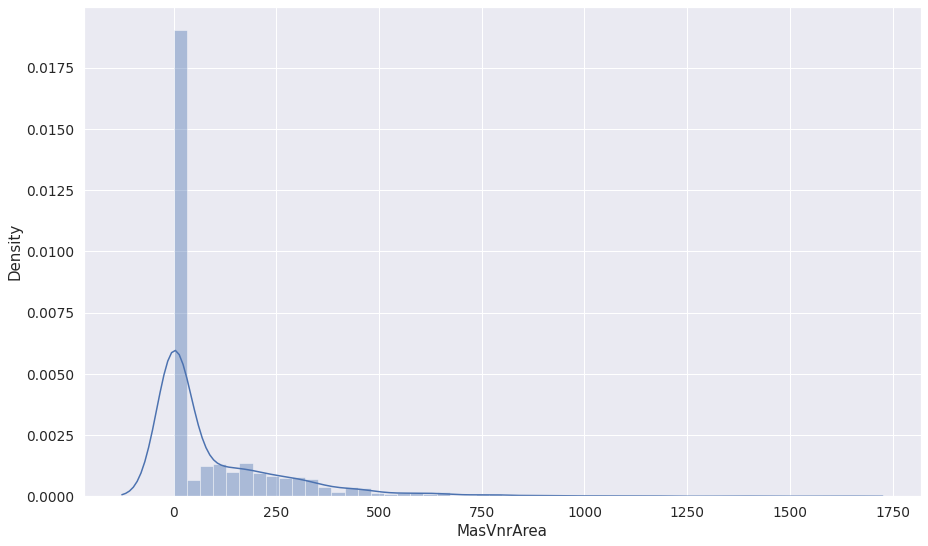

In [24]:
figure = plt.figure(figsize=(15, 9))
ax = sns.distplot(train['MasVnrArea'].fillna(0))

In [25]:
imputer = SimpleImputer(strategy='median')
train_num = imputer.fit_transform(train.select_dtypes(['int64', 'float64']))
test_num = imputer.transform(test.select_dtypes(['int64', 'float64']))

In [26]:
cat_columns = train.select_dtypes(['object']).columns
cat_imputer = CategoricalImputer()
train_cat = cat_imputer.fit_transform(train.loc[:, cat_columns].values)
test_cat = cat_imputer.transform(test.loc[:, cat_columns].values)

In [27]:
one_hot_encoder = OneHotEncoder()
combined_cat_data = np.vstack([train_cat, test_cat])
combined_cat = one_hot_encoder.fit_transform(combined_cat_data).todense()

train_cat = combined_cat[:train.shape[0]]
test_cat = combined_cat[train.shape[0]:]

In [28]:
#Creating a scaler for input features
X_scaler = MinMaxScaler()

#Transforming the input features of both train and test
train_num = X_scaler.fit_transform(train_num)
test_num = X_scaler.transform(test_num)

In [68]:
X_train = np.hstack((train_num, train_cat))
X_test = np.hstack((test_num, test_cat))

In [57]:
models = [GradientBoostingRegressor(learning_rate=0.05),
          RandomForestRegressor(n_estimators=200, random_state=1)]
errors = []
for model in models:
    model_name = model.__class__.__name__
    error = np.sqrt(abs(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))).mean()
    errors.append([model_name, error])
    
result_df = pd.DataFrame(errors, columns=['Model name', 'Average error'])

In [58]:
result_df

,Model name,Average error
0,GradientBoostingRegressor,0.1492
1,RandomForestRegressor,0.1515


In [86]:
forest = forest = RandomForestRegressor(n_estimators=400, criterion='mse', oob_score=True, random_state=1,n_jobs=-1)
error = np.sqrt(abs(cross_val_score(forest, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))).mean()
print(f'Model: {forest.__class__.__name__}, Average error: {error}')

forest.fit(X_train, y_train)
predictions = forest.predict(X_test)
# Reversing the log transformation
predicted_saleprice = np.exp(predictions)

Model: RandomForestRegressor, Average error: 0.151049083440349


In [82]:
submission_df = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': predicted_saleprice.flatten()})
submission_df.to_csv('submission.csv', index=False)
FileLink('submission.csv')

/content/submission.csv

In [83]:
submission_df.head()

,Id,SalePrice
0,1461,126793.9196
1,1462,153213.7896
2,1463,185524.0337
3,1464,181698.5815
4,1465,188415.6799
